# Stack Overflow Post Categorisation

In this project, we aim to build a system to compile common challenges faced by software developers along with their solutions. The challenges compiled in this system will be related to NLP and will be categorise based on the **xxx**.

The challenges and solutions are collected from Stack Overflow, which is commonly used among developers to share their problem in the discussion forums. The solution provided on Stack Overflow are written by experience developers, making them more credible compared to ChatGPT. Therefore, with this system, we aim to categorise each post to increase efficiency in finding solution to any challenges related to NLP within developers in our company.

# 1. Data collection

We begin with collecting the challenges and solutions from Stack Overflow using Stack Exchange API. The documentation provided by the Stack Exchange API offers a comprehensive explanation on how to utilize their API to collect the desired data [1].

In Stack Overflow, each post consist of a question, tags, and identifier indicating whether it has answer and whether it also has an accepted answer. An accepted answer means that the author who post a questions, received an answer that worked for them personally [2]. Often, this means the answer provided by the forum successfully resolve their issue. Other than that, each post also has one or more tags, which is a word or phrase that describes the topic of the question [3].

The data collected in our project includes questions and answers related to NLP topic. To obtain this, we retrieve data with tags related to NLP, mainly from the `nlp` tag, and we only retrieve posts that have an accepted answer. We utilize the advanced search feature provided by the Stack Exchange API that helps generate a URL that can meets our data request requirements [4]. Through this advanced search, we obtain a URL that retrieves posts with accepted answers relevant to our tags.

The result provide us with the accepted answer id, which we will use to request the answer body from the API. Therefore, we will perform two data request to the API, one for posts (containing the question, tags, and accepted answer id) and another for the accepted answer content. So, in the end, we will connect both results to obtain a single file that compiles posts consisting of questions and its accepted answer.

In [1]:
import requests
import json



# Define a class to perform data collection
class get_stackoverflow_data:

  def __init__(self, tag, num_of_data, filename):

    self.tags = tag
    self.num_of_data = num_of_data
    self.filename = filename
    self.params = {
        "site": "stackoverflow",
        "filter": "withbody",
        "pagesize": 100}
    self.proxies = {
            "http": "http://13.115.194.123:20202",
            "https": "http://13.115.194.123:20202"
        }


  def get_stackoverflow_posts(self):

    # Get posts that has accepted answer with advanced search url
    post_url = "https://api.stackexchange.com/2.3/search/advanced?order=desc&sort=activity&accepted=True"

    # Finalise the parameters that want to be used to retrieve posts from the API
    self.post_params = self.params.copy()
    self.post_params["tagged"] = self.tags[0]

    # Initialise variables to store the current row, page, and tag in the looping
    num_of_retrieved_data = 0
    page = 1
    curr_tags = 0

    # Initialise variable to store the posts results
    self.posts_with_accepted_answer_id = []
    self.post_ids = set()

    # Perform looping to retrieve post data from multiple tags
    for tag in self.tags:
      page = 1

      while num_of_retrieved_data < self.num_of_data:
        self.post_params["tagged"] = tag
        self.post_params["page"] = page


  

        get_posts_with_accepted_answer_id = requests.get(post_url, params=self.post_params, proxies=self.proxies).json()
        if get_posts_with_accepted_answer_id.status_code == 502:  # API Throttle Error
          print("Rate limit exceeded. Please wait before making more requests.")
          return

        # The data sucessfully retrieved indicated with 'items' keys in the output
        if "items" in get_posts_with_accepted_answer_id:

          # Check the 'question_id' to avoid duplicated posts
          for post in get_posts_with_accepted_answer_id['items']:

            if post['question_id'] not in self.post_ids:
              self.posts_with_accepted_answer_id.append(post)
              self.post_ids.add(post['question_id'])
              num_of_retrieved_data += 1

              if num_of_retrieved_data >= self.num_of_data:
                break

          page += 1

        else:
          # Move to the next tag if there's no more result contained
          break

    # Print a message if the target number of data has not been achieved
    if num_of_retrieved_data < self.num_of_data:
      print("The requested number of data exceeds the currently available data.")

    print(f"Total {num_of_retrieved_data} posts sucessfully retrieved from the \"{self.tags}\" tags.")

  def get_stackoverflow_answers(self):

    # Compile the accepted_answer_id into a list
    accepted_answer_ids = []

    for post in self.posts_with_accepted_answer_id:
      accepted_answer_ids.append(str(post['accepted_answer_id']))

    # Return the answer 'body' into a dictionary with format: 'answer_id' as the key and 'body' as the value
    self.answer_body = {}

    # Perform looping since the max size for each request are 100 semicolon delimited ids
    for page in range(0, len(accepted_answer_ids), self.params['pagesize']):

      sliced_accepted_answer_ids = accepted_answer_ids[page:page+self.params['pagesize']]

      accepted_answer_ids_str = ";".join(sliced_accepted_answer_ids)

      # Get the accepted answer body with filtering by 'accepted_answer_id' for each post
      answer_url = f"https://api.stackexchange.com/2.3/answers/{accepted_answer_ids_str}"

      get_answer_body = requests.get(answer_url, params=self.params,proxies=self.proxies).json()

      for answer in get_answer_body["items"]:
        self.answer_body[answer['answer_id']] = answer['body']

    print(f"Total {len(self.answer_body)} accepted answered sucessfully retrieved from each posts.")


  def get_stackoverflow_posts_answers(self):

    # Mapped the answer body by 'accepted_answer_id' into the posts question
    for post in self.posts_with_accepted_answer_id:
      post['answer_body'] = self.answer_body[post['accepted_answer_id']]

    # Save the result into a json file
    with open("./data/" + self.filename, 'w') as file:
      json.dump(self.posts_with_accepted_answer_id, file)

    print(f"Output successfully saved into {self.filename}.")

In [ ]:
# Collecting posts from multiple tags combination
tags_nlp_related = ["nlp","tokenize","recurrent-neural-network","python;text-classification","python;regex","machine-learning;text","python;lstm","python;visualisation"]
stackoverflow_df = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=20000, filename='stack_overflow_posts_nlp.json')
stackoverflow_df.get_stackoverflow_posts()

In [5]:
# Collecting accepted answer and save into a json file
stackoverflow_df.get_stackoverflow_answers()
stackoverflow_df.get_stackoverflow_posts_answers()

KeyError: 'items'

In [6]:
# Collecting posts with MORE tags combination
tags_nlp_related = ["nlp","tokenize","recurrent-neural-network","python;text-classification","python;regex","machine-learning;text","python;lstm","python;visualisation","macihne-learning","deep-learning"]
stackoverflow_df = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=200, filename='stack_overflow_posts_nlp_v2.json')
stackoverflow_df.get_stackoverflow_posts()

SSLError: HTTPSConnectionPool(host='api.stackexchange.com', port=443): Max retries exceeded with url: /2.3/search/advanced?order=desc&sort=activity&accepted=True&site=stackoverflow&filter=withbody&pagesize=100&tagged=nlp&page=1 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))

In [167]:
# Import the json data to notebook
import pandas as pd
import json

with open('./data/stack_overflow_posts_nlp.json', 'r') as file_output:
    jstr = file_output.read()
    jdata = json.loads(jstr)

posts_df = pd.json_normalize(jdata)

In [168]:
# Tidying the dataset
tidy_posts_df = posts_df[['title', 'body', 'tags', 'answer_body', 'score', 'view_count', 'creation_date', 'is_answered', 'link']]
tidy_posts_df.head()

,title,body,tags,answer_body,score,view_count,creation_date,is_answered,link
0,Using Stanford CoreNLP,<p>I am trying to get around using the Stanfor...,"[java, eclipse, nlp, stanford-nlp]",<p>I found similar problem when building small...,7,9436,1327296584,True,https://stackoverflow.com/questions/8967544/us...
1,Save only best weights with huggingface transf...,"<p>Currently, I'm building a new transformer-b...","[deep-learning, nlp, pytorch, huggingface-tran...",<p>You may try the following parameters from t...,18,23350,1592873636,True,https://stackoverflow.com/questions/62525680/s...
2,NLP with Racket,<p>I am studying NLP with Racket and Dr. Racke...,"[nlp, lisp, racket]",<p>The problem is with this form:</p>\n\n<pre>...,1,556,1477401051,True,https://stackoverflow.com/questions/40240929/n...
3,Training a model to identify names appearing i...,<p>I have a dataset containing the names of ab...,"[machine-learning, nlp, named-entity-recognition]",<p>The specifics of the answer may vary accord...,1,2009,1532341830,True,https://stackoverflow.com/questions/51476682/t...
4,Trouble getting importing gensim to work in colab,<p>I am trying to import gensim into colab.</p...,"[numpy, nlp, dependencies, google-colaboratory...",<p>You have to restart the session for the und...,0,58,1742481362,True,https://stackoverflow.com/questions/79523269/t...


# 2. Data Preprocessing

In [169]:
# Define function to perform text preprocessing and categorise ratings
import re
import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy


stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 5_000_000  # Increase the maximum allowed text length for lemmatisation

# Function to remove unnecessary characters, tags, and links
def regex_text(text):

  # Remove paragraph tags: <p> and </p>
  text = re.sub(r'</?p>', '', text)

  # Replace newline characters (\n) with spaces
  text = re.sub(r'\n', ' ', text)

  # Remove code block: <pre...><code>...</code></pre> including the content inside
  text = re.sub(r'<pre.*?><code>.*?</code></pre>', '', text)

  # Remove block quote tags: <blockquote> and <\blockquote> tags, keeping the content inside
  text = re.sub(r'</?blockquote>', '', text)

  # Remove link tags: <a> and </a> tags, keeping the content inside
  text = re.sub(r'</?a.*?>', '', text)

  # Remove inline code tags: <code> and </code> tags, keeping the content inside
  text = re.sub(r'</?code>', '', text)

  # Remove header tags: <h3> and </h3> tags, keeping the content inside
  text = re.sub(r'</?h3>', '', text)

  # Remove image tags: <img> tags
  text = re.sub(r'<img.*?>', '', text)

  # Remove "https://" URLs in the text
  text = re.sub(r'https://\S+', '', text)

  # Remove double quote in the text
  text = re.sub(r'&quot;', '', text)

  # Remove any non-alphanumeric characters by keeping only letters, numbers, and spaces using regex
  text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

  return text

# Function to preprocess text, optionally apply regex, remove stopwords, apply lemmatisation and lowercasing (Accept text or tokenized input)
def text_preprocessing(text, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=False, input_tokens=False, return_tokens=False):



    # Apply regex
    if regex:
        text = regex_text(text)

    # Lowercasing
    if lower_case:
        text = text.lower()

    # Tokenize the text
    if not input_tokens:
        tokens = word_tokenize(text)
    else:
        tokens = text

    # Remove stopwords
    if remove_stop_word:
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(tokens)

    # Lemmatisation
    if lemmatisation:
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]

    # Return the cleaned text or tokens
    if return_tokens:
        return tokens
    else:
        return " ".join(tokens)

In [ ]:
# make train_posts["tags"] into string
tidy_posts_df.loc[:, "tags"] = tidy_posts_df["tags"].apply(lambda x: " ".join(x))

In [ ]:



total_posts = len(tidy_posts_df)

#split data into same amount of data three parts
train_posts = tidy_posts_df[:total_posts//3].copy()
valid_posts = tidy_posts_df[total_posts//3:2*total_posts//3].copy()
test_posts = tidy_posts_df[2*total_posts//3:].copy()

# print(f"Total posts: {total_posts}")
# print(f"Train posts: {len(train_posts)}")
# print(f"Valid posts: {len(valid_posts)}")
# print(f"Test posts: {len(test_posts)}")


new_convi = ["title_stop_remov","body_stop_remov","title_body_stop_remov","title_body_answer_stop_remov"]
original = ["title","body","title_body","title_body_answer"]

train_posts["title_body"] = train_posts["title"] + " " + train_posts["body"]
train_posts["title_body_answer"] = train_posts["title_body"] + " " + train_posts["answer_body"]



# for LDA model
for new_val, ori_val in zip(new_convi, original):
    train_posts[new_val] = train_posts[ori_val].copy().apply(lambda x: text_preprocessing(x, regex=True, remove_stop_word=True, lemmatisation=True, lower_case=True))



# for BERT model
for valuable in ["title","body","answer_body","title_body"]:
    train_posts[f"{valuable}"] = train_posts[f"{valuable}"].apply(lambda x: text_preprocessing(x, regex=True, remove_stop_word=False, lemmatisation=True, lower_case=True))






# 3.	Graphical representation of the dataset 

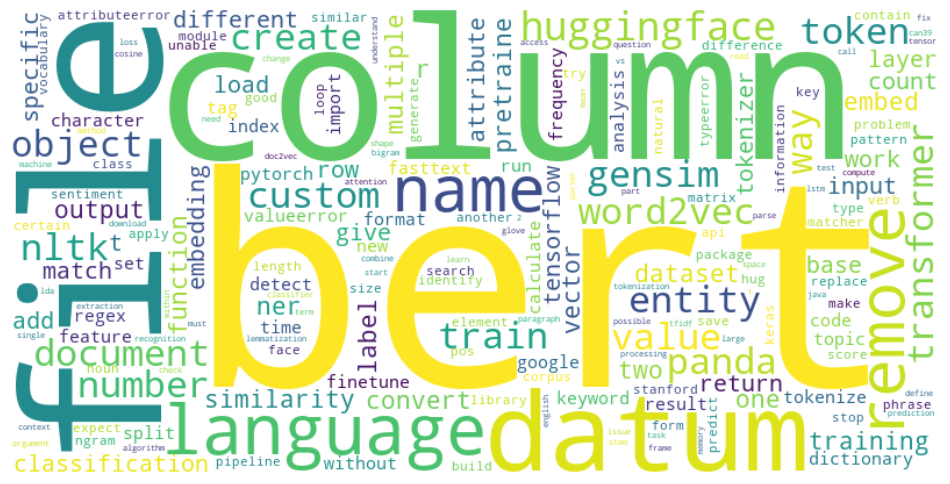

In [172]:
# using word cloud to visualise the most frequent words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter




def plot_worldcloud(data, feature, num_remove = 0):

    whole_text = " ".join(data[feature])

    # Count word frequencies
    word_freq = Counter(whole_text.split())

    # Remove the top 2 most common words
    most_common = word_freq.most_common(num_remove)
    for word, _ in most_common:
        del word_freq[word]



    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()



plot_worldcloud(train_posts, "title_stop_remov", num_remove=15)




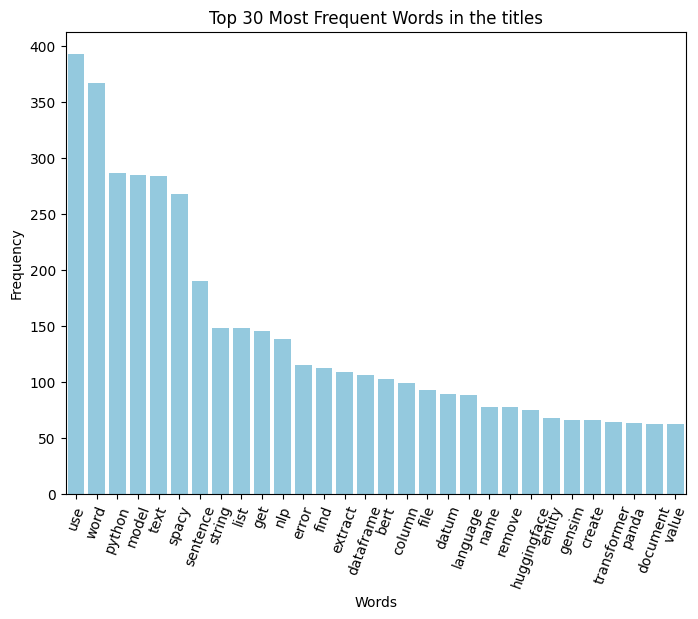

In [173]:
# check the frequency of the words in the text
from collections import Counter
import nltk
import seaborn as sns


token_series = train_posts['title_stop_remov'].copy()
token_series = token_series.apply(lambda x: word_tokenize(x))

all_tokens = [token for tokens in token_series for token in tokens]
counter = Counter(all_tokens)
# counter.most_common(20)

# delete the top 2 most common words
for word, _ in counter.most_common(0):
    del counter[word]



most_com = 30
plt.figure(figsize=(8, 6))
sns.barplot(x=[word for word, _ in counter.most_common(most_com)], 
             y=[count for _, count in counter.most_common(most_com)], color="skyblue")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=70)
plt.title(f'Top {most_com} Most Frequent Words in the titles')
plt.show()



# 4.	Categorisation of the posts

# LDA (Latent Dirichlet Allocation) for topic modeling

Preprocess Your Titles

In [176]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora

# nltk.download('punkt')
# nltk.download('stopwords')


# Load your text data
documents = train_posts["title_stop_remov"].copy().astype(str).tolist()


processed_docs = [text_preprocessing(doc, return_tokens=True) for doc in documents]

# remove the first 2 most common tokens
for word, _ in Counter([token for tokens in processed_docs for token in tokens]).most_common(30):
    for doc in processed_docs:
        if word in doc:
            doc.remove(word)



Create Dictionary and Corpus

In [177]:
# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_docs)
# print(dictionary)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Train LDA Model

In [178]:
"""

from gensim.models import LdaModel
from gensim.models import CoherenceModel
coherence_score = []


for i in range(35, 50):
    # Create the LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=i,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )

    # Compute coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=processed_docs,
        dictionary=dictionary,
        coherence='c_v'  # or 'u_mass', 'c_uci', 'c_npmi'
    )
    coherence_score.append(coherence_model_lda.get_coherence())
    print(f"Number of Topics: {i}, Coherence Score: {coherence_score[-1]:.4f}")


"""

'\n\nfrom gensim.models import LdaModel\nfrom gensim.models import CoherenceModel\ncoherence_score = []\n\n\nfor i in range(35, 50):\n    # Create the LDA model\n    lda_model = LdaModel(\n        corpus=corpus,\n        id2word=dictionary,\n        num_topics=i,\n        random_state=42,\n        passes=10,\n        alpha=\'auto\',\n        per_word_topics=True\n    )\n\n    # Compute coherence score\n    coherence_model_lda = CoherenceModel(\n        model=lda_model,\n        texts=processed_docs,\n        dictionary=dictionary,\n        coherence=\'c_v\'  # or \'u_mass\', \'c_uci\', \'c_npmi\'\n    )\n    coherence_score.append(coherence_model_lda.get_coherence())\n    print(f"Number of Topics: {i}, Coherence Score: {coherence_score[-1]:.4f}")\n\n\n'

In [179]:

from gensim.models import LdaModel

num_topics = 48  # You can change this
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

Display Topics

In [180]:
topics = lda_model.print_topics(num_words=20)
for topic_num, topic in topics:
    print(f"Topic {topic_num}: {topic}")

Topic 25: 0.075*"0" + 0.046*"package" + 0.035*"task" + 0.034*"rnn" + 0.029*"avoid" + 0.027*"pickle" + 0.025*"date" + 0.024*"stopwords" + 0.024*"go" + 0.022*"translate" + 0.022*"working" + 0.020*"count" + 0.020*"nltk" + 0.020*"stopword" + 0.020*"representation" + 0.019*"add" + 0.017*"39str39" + 0.017*"1" + 0.017*"postgresql" + 0.017*"jupyter"
Topic 9: 0.159*"keyword" + 0.113*"library" + 0.070*"analyze" + 0.055*"store" + 0.052*"summarization" + 0.050*"rule" + 0.047*"filter" + 0.029*"importerror" + 0.018*"module" + 0.008*"three" + 0.005*"openai" + 0.005*"opennlp" + 0.003*"azure" + 0.003*"structuredoutput" + 0.003*"rake" + 0.003*"technical" + 0.003*"39isin39" + 0.003*"39deprecated39" + 0.003*"39typingextensions39" + 0.003*"39berttokenizerfast39"
Topic 31: 0.063*"accuracy" + 0.058*"regex" + 0.040*"well" + 0.032*"repeat" + 0.031*"r" + 0.026*"unicode" + 0.026*"around" + 0.023*"entity" + 0.021*"several" + 0.021*"comment" + 0.019*"c" + 0.019*"insert" + 0.019*"integer" + 0.017*"package" + 0.017*

Assign Topics to Each Title

In [181]:
topic_assignments = []
for doc_bow in corpus:
    topic_probs = lda_model.get_document_topics(doc_bow)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    topic_assignments.append(dominant_topic)

# Attach to your original DataFrame
train_posts["LDA_topic"] = topic_assignments

In [182]:
# define a new category depends on the LDA_topic





Visualize Topics with pyLDAvis

In [165]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.025535  0.136122       1        1  2.794529
17     0.021135 -0.102178       2        1  2.779953
22     0.080474 -0.091043       3        1  2.720206
24     0.127719  0.016297       4        1  2.646745
13    -0.102419 -0.048579       5        1  2.567890
18     0.039674 -0.062223       6        1  2.484791
36    -0.048488 -0.004749       7        1  2.470038
21    -0.190681  0.015771       8        1  2.416686
8      0.006950 -0.003063       9        1  2.409534
40     0.021595  0.010623      10        1  2.385628
6      0.027267  0.103013      11        1  2.366544
3     -0.026656 -0.101607      12        1  2.355822
27    -0.081891 -0.165102      13        1  2.337026
12     0.037665 -0.039785      14        1  2.280453
44     0.062045 -0.161536      15        1  2.274769
29    -0.028934 -0.092739      16        1  2.220526
30     0.039620 -0.019279      17        1  2.198049
47    -0.018371  0.008470      18        1  2.192573
0      0.125396  0.002140      19        1  2.155334
41    -0.029134  0.005064      20        1  2.137258
7     -0.102238 -0.038271      21        1  2.126258
10    -0.075056  0.022226      22        1  2.082309
15    -0.244818  0.029051      23        1  2.068227
38     0.016924  0.063415      24        1  2.065007
14     0.031867 -0.013518      25        1  2.061727
4     -0.012156 -0.011571      26        1  2.027134
46     0.031797 -0.057368      27        1  2.023610
37     0.029715  0.078099      28        1  2.007748
5     -0.043846  0.016499      29        1  1.988294
26     0.053785  0.048381      30        1  1.966339
20    -0.136510  0.002496      31        1  1.944272
34     0.080352  0.022724      32        1  1.936978
28     0.038681  0.021258      33        1  1.920638
11    -0.025236  0.103567      34        1  1.890082
43     0.029911 -0.150129      35        1  1.854199
16     0.013372 -0.007859      36        1  1.820109
2      0.068879  0.015483      37        1  1.811929
33     0.022204  0.063277      38        1  1.811561
42     0.047248  0.062255      39        1  1.811186
31    -0.030705  0.082825      40        1  1.781648
32     0.033228  0.036425      41        1  1.773698
23     0.024374  0.008024      42        1  1.746176
1      0.027890  0.014872      43        1  1.728261
45     0.020742  0.054892      44        1  1.673069
25     0.038033  0.038241      45        1  1.607965
39    -0.019506  0.026822      46        1  1.485477
35     0.020203  0.020713      47        1  1.457327
9      0.023436  0.041553      48        1  1.334416, topic_info=              Term       Freq      Total Category  logprob  loglift
450         number  66.000000  66.000000  Default  30.0000  30.0000
630         return  57.000000  57.000000  Default  29.0000  29.0000
86        word2vec  56.000000  56.000000  Default  28.0000  28.0000
413         object  58.000000  58.000000  Default  27.0000  27.0000
341          match  47.000000  47.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
1514     loadmodel   0.435274   1.724014  Topic48  -5.8848   2.9402
419          azure   0.435463   2.147533  Topic48  -5.8843   2.7210
853    encorewebsm   0.435379   2.687737  Topic48  -5.8845   2.4964
288         module   2.853568  25.236195  Topic48  -4.0044   2.1370
994   incompatible   0.435274   4.043568  Topic48  -5.8848   2.0878

[1871 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
374      45  0.931489           0
808       6  0.695469           1
808      45  0.208641           1
26       44  0.581703          10
641      11  0.555608         100
...     ...       ...         ...
778       2  0.842297           x
1960     41  0.584956  xlmroberta
1863     14  0.821311       xlnet
1628     27  0.446037        zero
1362     15  0.554548    zeroshot

[1462 rows

# Quantitative Metrics to Evaluate LDA

In [85]:
# Perplexity (Lower = Better)
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")


Perplexity: -10.337234901874169


In [20]:
# Coherence Score (Higher = Better)
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=processed_docs,
    dictionary=dictionary,
    coherence='c_v'  # or 'u_mass', 'c_uci', 'c_npmi'
)
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score:.4f}")

Coherence Score: 0.5499


In [87]:
# Dominant Topic per Document
for i, doc_bow in enumerate(corpus[:5]):
    print(f"Title: {documents[i]}")
    print(lda_model.get_document_topics(doc_bow))
    print()

Title: use stanford corenlp
[(3, 0.657994)]

Title: save good weight huggingface transformer
[(9, 0.16846327), (19, 0.16856973), (24, 0.19414032), (30, 0.14279711), (46, 0.1690592)]

Title: nlp racket
[(0, 0.010442257), (1, 0.010398881), (2, 0.010461628), (3, 0.0112827), (4, 0.010195398), (5, 0.010479824), (6, 0.010365796), (7, 0.010521409), (8, 0.010736869), (9, 0.011305177), (10, 0.011520769), (11, 0.011612242), (12, 0.012553532), (14, 0.011416845), (16, 0.011822463), (17, 0.01228547), (18, 0.010967087), (19, 0.011607409), (20, 0.012433155), (21, 0.010696153), (24, 0.0111292), (25, 0.012881458), (27, 0.010368211), (29, 0.010139887), (30, 0.011480747), (32, 0.010267232), (33, 0.010589552), (34, 0.011267573), (35, 0.49192044), (36, 0.010215654), (37, 0.010181124), (38, 0.0111569995), (39, 0.010524957), (41, 0.010480357), (42, 0.010985914), (43, 0.010533484), (44, 0.0115102), (45, 0.010060426), (46, 0.013042934), (47, 0.010192773)]

Title: training model identify name appear sentence
[(

# BERT MODEL

prepare the data

In [ ]:
# prepare the text for training
whole_text = " ".join(train_posts["tags"])
# print(whole_text)

#  Tokenization Process & word embedding 

In [ ]:
from transformers import BertTokenizer, BertModel
import torch




text = "The quick brown fox jumps over the lazy dog."


#  Tokenization Process
# Load BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize with BERT tokenizer
bert_inputs = bert_tokenizer(text, return_tensors='pt')



print("Token IDs:", bert_inputs['input_ids'])

print("Attention Mask:", bert_inputs['attention_mask'])

print("Token Type IDs:", bert_inputs['token_type_ids'])

# Print the tokens themselves to understand the splits
tokens = bert_tokenizer.convert_ids_to_tokens(bert_inputs['input_ids'][0])
print("Tokens:", tokens)



# Obtain the embeddings
with torch.no_grad():
    outputs = bert_model(**bert_inputs)


# Extract the last hidden state (embeddings)
last_hidden_states = outputs.last_hidden_state

# Print the dimensions of the embeddings
print("Shape of the last hidden state (embeddings):", last_hidden_states.shape)

# Print embeddings for each token along with their vector dimension
for token, embedding in zip(tokens, last_hidden_states[0]):
    print(f"Token: {token}, Embedding Dimension: {embedding.shape}, Embedding (first 5 components): {embedding[:5]}...")  # Display first 5 components for brevity




# Sentence Embeddings

In [89]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# prepare the text for training
data_series = train_posts["title"].copy()
# print(title_series.head())



# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    sentence_embedding = torch.mean(last_hidden_states, dim=1).numpy()
    return sentence_embedding




# Example texts
data_series = data_series.astype(str).tolist()
# Generate embeddings for texts
embeddings = [get_sentence_embedding(text) for text in data_series]

In [156]:
# Query text
query_text = "bert tokenizer"
query_embedding = get_sentence_embedding(query_text)

# Compute cosine similarities
similarities = cosine_similarity(query_embedding, np.vstack(embeddings))

# Get the top 5 most similar texts
top_k = 5
top_indices = similarities[0].argsort()[-top_k:][::-1]
top_similar_texts = [data_series[i] for i in top_indices]
top_similarities = [similarities[0][i] for i in top_indices]


print("Top 5 most similar texts to the query: ", query_text,"\n")
for text, sim in zip(top_similar_texts, top_similarities):
    print(f"Text: {text}, Similarity: {sim:.4f}")

Top 5 most similar texts to the query:  bert tokenizer 

Text: tokenizer change vocabulary entry, Similarity: 0.8273
Text: nlp understand token id, Similarity: 0.8219
Text: training camelbert model for token classification, Similarity: 0.8109
Text: how to convert character index to bert token index, Similarity: 0.7945
Text: translation between different tokenizer, Similarity: 0.7888


# K-Mean Cluster

k=2, Silhouette Score=0.0684
k=3, Silhouette Score=0.0505
k=4, Silhouette Score=0.0380
k=5, Silhouette Score=0.0376
k=6, Silhouette Score=0.0408
k=7, Silhouette Score=0.0378
k=8, Silhouette Score=0.0361
k=9, Silhouette Score=0.0358
k=10, Silhouette Score=0.0338


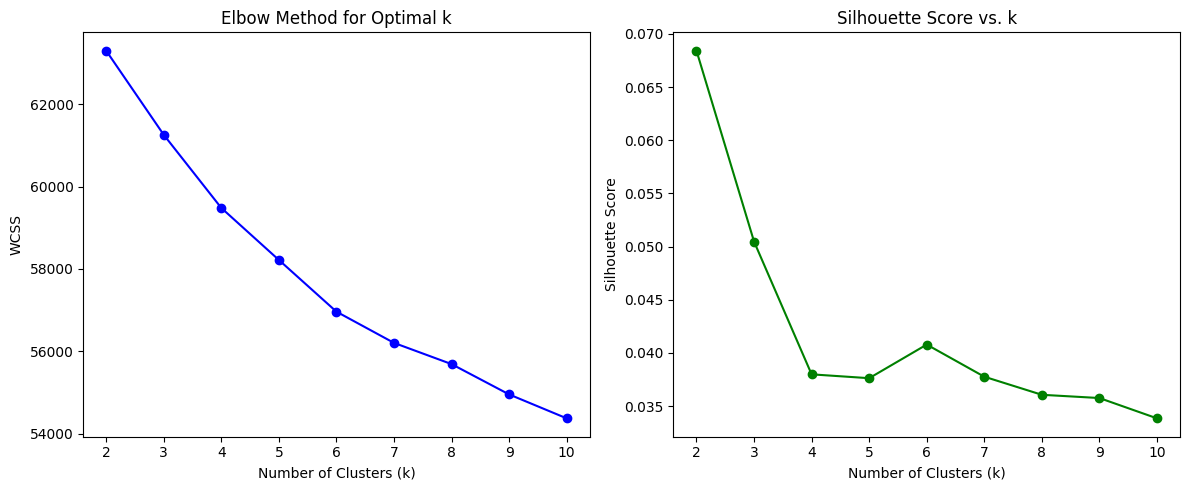

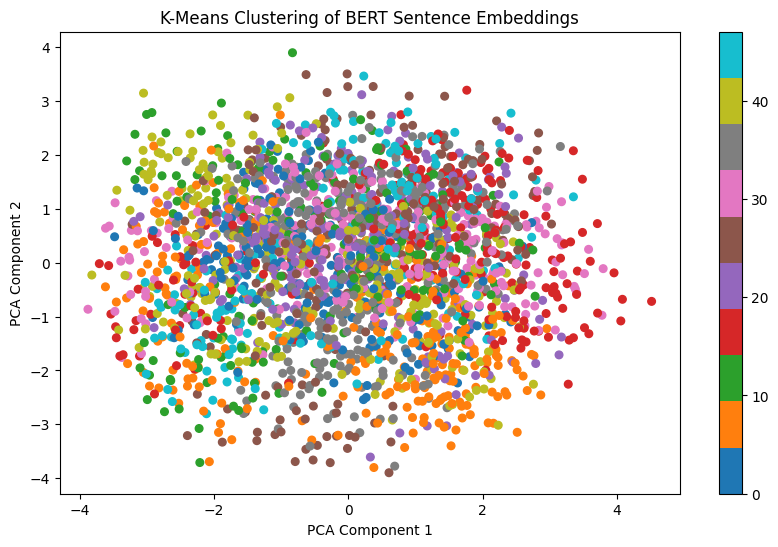

In [123]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score






embedding_matrix = np.vstack(embeddings)

# # Optional: reduce dimensionality for clustering stability
# pca = PCA(n_components=50)
# reduced_embeddings = pca.fit_transform(embedding_matrix)
# # Use `reduced_embeddings` if you uncomment the above




# ===================================================================


# X = reduced_embeddings
X = embedding_matrix

# ----- Elbow Method & Silhouette Score -----
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
K_range = range(2, 11)  # Try k from 2 to 10

for k in K_range:

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    # Calculate WCSS    
    wcss.append(kmeans.inertia_)  # WCSS

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}, Silhouette Score={silhouette_avg:.4f}")

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')

plt.tight_layout()
plt.show()




# ===================================================================


# Set number of clusters
num_clusters = 48  # choose based on your data or use methods like elbow/silhouette

# Fit KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_matrix)


# group data into new clusters called -1 if the number of data in the cluster are less than 10
for i in range(num_clusters):
    if np.sum(cluster_labels == i) < 10:
        cluster_labels[cluster_labels == i] = -1
        print(f"Cluster {i} has less than 10 data points and is set to -1")
    


# Add results to your original data
train_posts["cluster"] = cluster_labels

# Optional: Visualize in 2D using PCA
pca_2d = PCA(n_components=2)
points_2d = pca_2d.fit_transform(embedding_matrix)

plt.figure(figsize=(10, 6))
plt.scatter(points_2d[:, 0], points_2d[:, 1], c=cluster_labels, cmap='tab10', s=30)
plt.title("K-Means Clustering of BERT Sentence Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

In [125]:
# check how many clusters are there
sort_cluster = train_posts["cluster"].value_counts().sort_index()
sort_cluster.head(20)


cluster
0     34
1     57
2     27
3     76
4     38
5     62
6     39
7     46
8     73
9     65
10    43
11    42
12    38
13    26
14    42
15    52
16    80
17    60
18    50
19    39
Name: count, dtype: int64

# BERTopic

In [144]:
from bertopic import BERTopic

# Your list of post titles
documents = list(train_posts["title_body"].copy())

# Create BERTopic model
topic_model = BERTopic()

# Fit the model to your text data
topics, probs = topic_model.fit_transform(documents)


# Inspect the top topics
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1120,-1_the_to_be_of,"[the, to, be, of, and, in, for, this, it, use]",[some nlp stuff to do with grammar tagging ste...
1,0,168,0_bert_model_the_be,"[bert, model, the, be, to, use, token, hugging...",[finetune a bert model for context specific em...
2,1,158,1_tr_dataframe_column_td,"[tr, dataframe, column, td, styletextalign, ta...",[get jaccard similarity by compare all row in ...
3,2,77,2_frequency_count_word_of,"[frequency, count, word, of, in, number, the, ...",[typetoken ratio in google sheet how to manipu...
4,3,66,3_layer_error_shape_input,"[layer, error, shape, input, the, tensor, be, ...",[attention layer change batch size at inferenc...


 Visualize the topics

In [145]:
topic_model.visualize_topics()


In [147]:
# Show top words in a specific topic (e.g., topic 1)
print(topic_model.get_topic(1))  # == topics[-1]


# Or show representative documents
print(topic_model.get_representative_docs(1))


[('tr', 0.05921657525116409), ('dataframe', 0.043071295268529625), ('column', 0.03551702795669116), ('td', 0.025160531427966322), ('styletextalign', 0.025046028525820503), ('table', 0.02326906787315119), ('row', 0.022625604453554733), ('tbody', 0.022375887190812967), ('thead', 0.022375887190812967), ('div', 0.021056533338860206)]
['get jaccard similarity by compare all row in a panda dataframe while keep track of row be compare hi I would like to get the jaccard similarity between all row in a dataframe I already have a jaccard similarity function like the following which be take in two list but I could not get my head around how you can keep track of the user for which the comparison be be do   I would like to run this function against all the row in the dataframe div classstablecontainer table classstable thead tr thwordingsth thusersth tr thead tbody tr tdapplebananaorangepearstd tdadelinetd tr tr tdbananajackfruitberriesappletd tderickotd tr tr tdberriesgrapeswatermelontd tdmarytd 

In [151]:


# Add topics back to your DataFrame
train_posts["bert_topic"] = topics
train_posts["bert_topic_probability"] = probs

print(train_posts["bert_topic"].value_counts().head(10))

bert_topic
-1    1120
 0     168
 1     158
 2      77
 3      66
 4      41
 5      41
 6      39
 7      36
 8      36
Name: count, dtype: int64


# Metric for the evaluation of categorization 

topic Coherence Score (🧠 coherence = how meaningful topics are)

In [152]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Prepare your text data
docs = list(train_posts["title"])

# Get valid topic IDs (excluding -1 which is the outlier topic)
topic_info = topic_model.get_topic_info()
valid_topic_ids = topic_info[topic_info.Topic != -1]["Topic"].tolist()

# Get top words for each topic
topic_words = [
    [word for word, _ in topic_model.get_topic(topic_id)]
    for topic_id in valid_topic_ids
]

# Prepare dictionary and corpus for coherence evaluation
texts = [doc.split() for doc in docs]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build and evaluate coherence model
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'     # or ##rttbbttt'u_mass', 'c_uci', or 'c_npmi'
)
coherence_score = coherence_model.get_coherence()
print(f"Topic Coherence Score: {coherence_score:.4f}")

Topic Coherence Score: 0.3679


Topic Diversity Score (📚 are topics unique?)

In [153]:
def topic_diversity(topic_model, top_k=10):
    topic_words = topic_model.get_topics()
    top_words = set()
    total_words = 0
    for topic in topic_words.values():
        for word, _ in topic[:top_k]:
            top_words.add(word)
            total_words += 1
    return len(top_words) / total_words

diversity_score = topic_diversity(topic_model)
print(f"Topic Diversity Score: {diversity_score:.4f}")

Topic Diversity Score: 0.5913


# test the BERT-TOPIC model

In [157]:
new_docs = [
    "bert embedding in sparknlp",
    "american terr",
    "word2vec gensim fasttext vector",
]

new_topics, new_probs = topic_model.transform(new_docs)

for doc, topic, prob in zip(new_docs, new_topics, new_probs):
    print(f"'{doc}' → Topic {topic} (Confidence: {prob:.2f})")
    print(f"get_representative_docs({topic}): {topic_model.get_representative_docs(topic)}")
    print("===========================")




'bert embedding in sparknlp' → Topic 0 (Confidence: 1.00)
get_representative_docs(0): {-1: ['some nlp stuff to do with grammar tagging stemming and word sense disambiguation in python h1background tldr provide for the sake of completionh1 strongseeke advice on an optimal solution to an odd requirementstrong I m a literature student in my fourth year of college with only my own guidance in program I m competent enough with python that I will not have trouble implement solution I find most of the time and develop upon they but because of my newbness I m seek advice on the embestem way I might tackle this peculiar problem strongalready use nltk but differently from the example in the nltk bookstrong I m already utilize a lot of stuff from nltk particularly wordnet so that material be not foreign to I I ve read most of the nltk book strongim work with fragmentary atomic languagestrong user input word and sentence fragment and wordnet be use to find connection between the input and generate

# References:

1. https://api.stackexchange.com/docs
2. https://stackoverflow.com/help/accepted-answer
3. https://stackoverflow.com/help/tagging
4. https://api.stackexchange.com/docs/advanced-search#order=desc&sort=activity&accepted=True&tagged=nlp&filter=default&site=stackoverflow&run=true
2. https://api.stackexchange.com/docs/paging
3. https://api.stackexchange.com/docs/answers-by-ids
4. https://medium.com/@davidlfliang/intro-getting-started-with-text-embeddings-using-bert-9f8c3b98dee6